In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seml
from poisson_atac.utils import model_type_map
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

Global seed set to 0


In [3]:
from statannotations.Annotator import Annotator
import itertools

In [4]:
seml_collection = "neurips_challenge_evaluation"

In [5]:
fig_path = '/storage/groups/ml01/workspace/laura.martens/atac_poisson_data/panels/Figure2/'

In [9]:

def load_seml(seml_database, model_type_map, final=False, metric="rmse"):
    dataset_map = {'neurips': 'Neurips\nall batches'}
    
    results = seml.get_results(seml_database, to_data_frame=True,  fields=["config", "config_hash", "result", "batch_id"])
    
    results = results[results['config.training.final']==final]
    results['config.data.dataset'] = results['config.data.dataset'].map(dataset_map)
    #add LS-lab results
    results.loc[results['config.model.model_type'].isna(), 'config.model.model_type'] = results.loc[results['config.model.model_type'].isna(), 'config.model.method']
    
    results['config.setup.model_params.use_observed_lib_size'] = results['config.setup.model_params.use_observed_lib_size'].map({True: "True", np.nan: ''})
    #combine with results using mean library size
    df = merge_dataframe(results, metric)
    
    df['config.model.model_type'] = df['config.model.model_type'] + df['config.setup.model_params.use_observed_lib_size'].astype(str) 
    df["config.model.model_type"] = df["config.model.model_type"].map(model_type_map)
    
    return df

In [16]:
def merge_dataframe(results, metric):
    df = results.loc[:, [f"result.{metric}", "config.model.model_type", "config.setup.model_params.use_observed_lib_size", 'config.data.data_split', 'config.setup.model_params.n_latent']]
    df_mean = results.loc[:, ["config.model.model_type", 'config.data.data_split']]
    df_mean.loc[:, f'result.{metric}'] = pd.concat(results['result.test_cells'].values).loc[metric, "Mean"].values
    df_mean.loc[:, "config.setup.model_params.use_observed_lib_size"] = False
    df = pd.concat([df, df_mean.dropna()], axis=0)
    return df

In [11]:
def create_annotated_boxplot(data, pairs, x, y, hue, hue_order, order, test, ax, x_label=None, y_label=None, legend=True, y_lim=None):
    sns.boxplot(data = data, x=x, y=y, hue=hue, hue_order = hue_order, order=order, orient="h", ax=ax, palette="Blues")
    annot = Annotator(ax, pairs, data=data, x=x, y=y, order=order, hue=hue, hue_order=hue_order, orient="h")
    annot.configure(test=test, verbose=0, text_format='star', loc='inside')
    annot.apply_test()
    ax, test_results = annot.annotate()
    
        
    if x_label:
        plt.xlabel(x_label)
    else:
        plt.xlabel("")
        #plt.xlabel(x.split(".")[-1])
        
    if y_label:
        plt.ylabel(y_label)
    else:
        plt.ylabel("")
        ax.axes.get_yaxis().set_ticklabels([])
        #ax.axes.get_yaxis().set_visible(False)
        #plt.ylabel(y.split(".")[-1])
        
    if y_lim:
        plt.ylim(y_lim)
        
    if legend:
        plt.legend()
    else:
        ax.axes.get_legend().set_visible(False)
        
    plt.tight_layout()
    return ax

# Load hyperparameter search


In [19]:
metric="average_precision"
results = load_seml(seml_collection, model_type_map, final=False, metric=metric)

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

In [20]:
results

,result.average_precision,config.model.model_type,config.setup.model_params.use_observed_lib_size,config.data.data_split,config.setup.model_params.n_latent
11,0.263996,Poisson encoder-decoder\n(observed library size),True,0,10.0
12,0.264076,Poisson encoder-decoder\n(observed library size),True,0,20.0
13,0.264005,Poisson encoder-decoder\n(observed library size),True,0,30.0
14,0.264199,Poisson encoder-decoder\n(observed library size),True,0,40.0
15,0.264097,Poisson encoder-decoder\n(observed library size),True,0,50.0
...,...,...,...,...,...
116,0.189347,Binary encoder-decoder\n(mean observed library...,False,10,NaN
117,0.189144,Binary encoder-decoder\n(mean observed library...,False,10,NaN
118,0.189110,Binary encoder-decoder\n(mean observed library...,False,10,NaN
119,0.188439,Binary encoder-decoder\n(mean observed library...,False,10,NaN


In [22]:
results.groupby(['config.model.model_type', 'config.setup.model_params.n_latent']).agg({f'result.{metric}': 'median'}).sort_values(f'result.{metric}')

result.average_precision
config.model.model_type                          config.setup.model_params.n_latent                          
Binary encoder-decoder\n(observed library size)  10.0                                                0.262177
                                                 20.0                                                0.262287
                                                 30.0                                                0.262294
                                                 40.0                                                0.262464
                                                 50.0                                                0.262472
Poisson encoder-decoder\n(observed library size) 10.0                                                0.263996
                                                 30.0                                                0.264005
                                                 20.0                                                0.264076
                                                 50.0                                                0.264097
                                                 40.0                                                0.264199

# Load results of final evaluation

In [23]:
model_order = [model_type_map['LS_lab'], model_type_map['gex_binaryFalse'], model_type_map["gexFalse"] , model_type_map['gex_binaryTrue'], model_type_map["gexTrue"]]

In [24]:
results = load_seml(seml_collection, model_type_map, final=True, metric=metric)

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

In [25]:
results.shape

(55, 5)

# Plot results

In [28]:
pairs = list(itertools.combinations(results['config.model.model_type'].unique(), 2))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


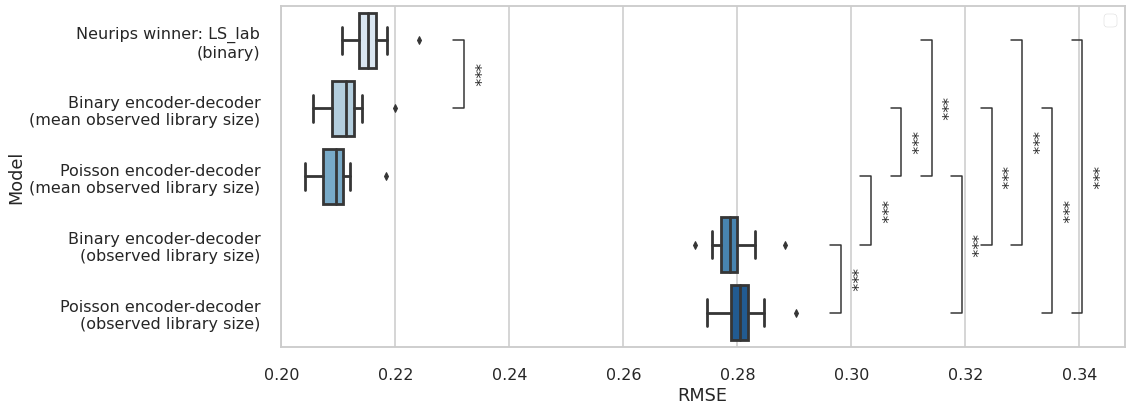

In [29]:
fig, ax = plt.subplots(figsize=(16,6))
ax = create_annotated_boxplot(data = results, pairs=pairs, x=f"result.{metric}", y="config.model.model_type", hue=None, order=model_order, hue_order=None, ax = ax, test='Wilcoxon', y_label="Model", x_label="RMSE")
#fig.savefig(os.path.join(fig_path, "Neurips_challenge_RMSE.pdf"))
#fig.savefig(os.path.join(fig_path, "Neurips_challenge_RMSE.png"))

In [ ]:
# I should redo the analysis and choose optimal n_latent etc on train set